# TimeGAN Tutorial

## Time-series Generative Adversarial Networks

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

- Last updated Date: April 24th 2020

- Code author: Jinsung Yoon (jsyoon0823@gmail.com)

This notebook describes the user-guide of a time-series synthetic data generation application using timeGAN framework. We use Stock, Energy, and Sine dataset as examples.

### Prerequisite
Clone https://github.com/jsyoon0823/timeGAN.git to the current directory.

## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [1]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [2]:
## Data loading
data_name = 'stock'
seq_len = 5

if data_name in ['stock', 'energy']:
    ori_data, scaler= real_data_loading(data_name, seq_len)
elif data_name == 'sine':
    # Set number of samples and its dimensions
    no, dim = 10000, 5
    ori_data = sine_data_generation(no, seq_len, dim)
    
print(data_name + ' dataset is ready.')

stock dataset is ready.


## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [3]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'lstm' 
parameters['hidden_dim'] = 5
parameters['num_layer'] = 3
parameters['iterations'] = 20000
parameters['batch_size'] = 128

## Run TimeGAN for synthetic time-series data generation

TimeGAN uses the original data and network parameters to return the generated synthetic data.

In [4]:
# Run TimeGAN
generated_data = timegan(ori_data, parameters)   
print('Finish Synthetic Data Generation')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Start Embedding Network Training
step: 0/20000, e_loss: 0.3313
step: 1000/20000, e_loss: 0.2775
step: 2000/20000, e_loss: 0.2846
step: 3000/20000, e_loss: 0.2742
step: 4000/20000, e_loss: 0.2939
step: 5000/20000, e_loss: 0.2767
step: 6

## Evaluate the generated data

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [5]:
metric_iteration = 10

discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc = discriminative_score_metrics(ori_data, generated_data)
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use tf.global_variables instead.
Discriminative score: 0.4844


## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [6]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(ori_data, generated_data)
  predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

Predictive score: 0.1364


## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

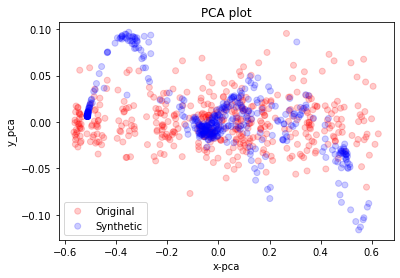

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 900 samples in 0.039s...
[t-SNE] Computed neighbors for 900 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 900 / 900
[t-SNE] Mean sigma: 0.006960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.982838
[t-SNE] KL divergence after 300 iterations: 0.461392


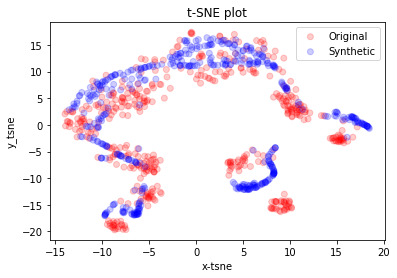

In [7]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')

In [8]:
generated_data.shape

(450, 5, 50)

In [9]:
print(len(ori_data), len(ori_data[0]))

450 5


# reshape data

In [10]:
g_data = np.reshape(generated_data, (generated_data.shape[0] * generated_data.shape[1], generated_data.shape[2]))

In [11]:
g_data = scaler.inverse_transform(g_data)

In [12]:
g_data[0]

array([1.67807608e+06, 8.37900524e+03, 1.56271328e+13, 4.71998746e+03,
       1.20775380e+06, 8.38249003e+03, 1.00000000e+00, 1.09021500e+08,
       1.79305408e+08, 2.59919408e+03, 6.29944698e+01, 1.26485785e+07,
       1.52177319e+07, 1.24712542e+06, 1.92121460e+13, 5.34296825e+01,
       1.93148948e+13, 5.88335770e+08, 1.24728291e+06, 2.43161667e+01,
       1.56581553e+10, 7.58737247e+03, 5.63623684e+01, 4.00318621e+05,
       2.37891030e-01, 4.75381324e+03, 6.54477614e+09, 1.83014179e+10,
       1.04646694e+03, 5.66283338e+06, 1.22473290e-01, 2.65757021e+11,
       3.76791387e+08, 2.78735536e+06, 1.91832186e+06, 2.81188510e+06,
       4.62677074e+03, 7.93224132e+12, 1.15950412e+00, 1.13298726e+06,
       3.60441006e+08, 1.21226642e+06, 9.52251446e+01, 1.86061184e+08,
       6.36934025e+01, 2.84965461e+06, 3.73616045e+12, 2.30612117e+08,
       3.76881717e+12, 1.21516770e+06])

In [13]:
df_generated = pd.DataFrame(g_data)

In [14]:
df_generated.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.678076e+06,8379.005238,1.562713e+13,4719.987455,1.207754e+06,8382.490027,1.0,1.090215e+08,1.793054e+08,2599.194081,...,3.604410e+08,1.212266e+06,95.225145,1.860612e+08,63.693402,2.849655e+06,3.736160e+12,2.306121e+08,3.768817e+12,1.215168e+06
1,1.674156e+06,7905.292871,1.553517e+13,4676.040850,1.213880e+06,7906.543820,1.0,1.056386e+08,1.790798e+08,868.410212,...,3.594963e+08,1.193470e+06,104.131196,1.855763e+08,63.799253,2.866321e+06,3.715921e+12,2.300202e+08,3.748822e+12,1.219303e+06
2,1.675013e+06,7982.766149,1.556770e+13,4682.998725,1.213094e+06,7985.444161,1.0,1.070430e+08,1.791957e+08,1261.940594,...,3.596661e+08,1.201278e+06,108.841790,1.857174e+08,63.767251,2.868615e+06,3.723233e+12,2.302330e+08,3.756099e+12,1.216584e+06
3,1.675570e+06,8080.662325,1.556666e+13,4691.977908,1.212203e+06,8084.718096,1.0,1.069792e+08,1.791785e+08,1634.994834,...,3.598733e+08,1.200140e+06,111.271032,1.856898e+08,63.738482,2.868964e+06,3.722998e+12,2.302243e+08,3.755868e+12,1.214889e+06
4,1.675433e+06,8058.909265,1.556384e+13,4689.966790,1.212418e+06,8062.706460,1.0,1.068690e+08,1.791710e+08,1558.403676,...,3.598280e+08,1.199540e+06,110.942445,1.856779e+08,63.742715,2.869028e+06,3.722370e+12,2.302061e+08,3.755246e+12,1.215156e+06


In [15]:
df_generated.shape

(2250, 50)

In [16]:
df_ori = pd.read_csv('./data/stock_data.csv')

In [17]:
df_ori.shape

(455, 50)

In [18]:
df_generated.columns = df_ori.columns

In [19]:
# df_generated = df_generated.astype(int)

In [20]:
df_generated.head()

,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes,v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries,v_/devices#RR-01/power_state,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts,v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw,...,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/used-memory,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-table-version,v_/devices#IntGW-02/metrics/disk-device-write-bytes-rate,v_/ports#link-tr-intgw-b-3-x/metrics/network-incoming-bytes,v_/devices#IntGW-01/metrics/cpu_util,v_/ports#link-tr-intgw-a-1-x/metrics/network-incoming-bytes-rate,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes,v_/ports#IntGW-02/metrics/network-incoming-packets,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes-rate
0,1.678076e+06,8379.005238,1.562713e+13,4719.987455,1.207754e+06,8382.490027,1.0,1.090215e+08,1.793054e+08,2599.194081,...,3.604410e+08,1.212266e+06,95.225145,1.860612e+08,63.693402,2.849655e+06,3.736160e+12,2.306121e+08,3.768817e+12,1.215168e+06
1,1.674156e+06,7905.292871,1.553517e+13,4676.040850,1.213880e+06,7906.543820,1.0,1.056386e+08,1.790798e+08,868.410212,...,3.594963e+08,1.193470e+06,104.131196,1.855763e+08,63.799253,2.866321e+06,3.715921e+12,2.300202e+08,3.748822e+12,1.219303e+06
2,1.675013e+06,7982.766149,1.556770e+13,4682.998725,1.213094e+06,7985.444161,1.0,1.070430e+08,1.791957e+08,1261.940594,...,3.596661e+08,1.201278e+06,108.841790,1.857174e+08,63.767251,2.868615e+06,3.723233e+12,2.302330e+08,3.756099e+12,1.216584e+06
3,1.675570e+06,8080.662325,1.556666e+13,4691.977908,1.212203e+06,8084.718096,1.0,1.069792e+08,1.791785e+08,1634.994834,...,3.598733e+08,1.200140e+06,111.271032,1.856898e+08,63.738482,2.868964e+06,3.722998e+12,2.302243e+08,3.755868e+12,1.214889e+06
4,1.675433e+06,8058.909265,1.556384e+13,4689.966790,1.212418e+06,8062.706460,1.0,1.068690e+08,1.791710e+08,1558.403676,...,3.598280e+08,1.199540e+06,110.942445,1.856779e+08,63.742715,2.869028e+06,3.722370e+12,2.302061e+08,3.755246e+12,1.215156e+06


In [21]:
df_final = pd.DataFrame(df_generated)
print(df_final.shape)

(2250, 50)


In [22]:
# df_generated.dtypes
int_columns = df_final.columns
int_columns_list = int_columns.values.tolist()
int_columns_list.remove('v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate')
int_columns_list.remove('v_/ports#link-intgw-exgw-b-1-x/metrics/network-outgoing-bytes-rate')
int_columns_list.remove('v_/ports#link-tr-intgw-b-3-y/metrics/network-outgoing-packets-rate')

df_final[int_columns_list] = df_final[int_columns_list].astype('int64')
df_final.shape

(2250, 50)

In [23]:
df_final.head()

,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes,v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries,v_/devices#RR-01/power_state,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts,v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw,...,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/used-memory,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-table-version,v_/devices#IntGW-02/metrics/disk-device-write-bytes-rate,v_/ports#link-tr-intgw-b-3-x/metrics/network-incoming-bytes,v_/devices#IntGW-01/metrics/cpu_util,v_/ports#link-tr-intgw-a-1-x/metrics/network-incoming-bytes-rate,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes,v_/ports#IntGW-02/metrics/network-incoming-packets,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes-rate
0,1678076,8379,15627132766033,4719,1.207754e+06,8382,1,109021500,179305407,2599,...,360441006,1212266,95,186061183,63,2849654,3736160451472,230612116,3768817172997,1215167
1,1674156,7905,15535173382632,4676,1.213880e+06,7906,1,105638559,179079804,868,...,359496298,1193469,104,185576327,63,2866321,3715921330872,230020220,3748821847265,1219302
2,1675012,7982,15567703348758,4682,1.213094e+06,7985,1,107042970,179195662,1261,...,359666053,1201278,108,185717432,63,2868614,3723232842313,230232960,3756098753093,1216584
3,1675570,8080,15566655529307,4691,1.212203e+06,8084,1,106979244,179178534,1634,...,359873281,1200140,111,185689771,63,2868963,3722997849058,230224323,3755868484016,1214888
4,1675432,8058,15563836960460,4689,1.212418e+06,8062,1,106869025,179170950,1558,...,359828027,1199539,110,185677885,63,2869027,3722370452559,230206142,3755246317885,1215156


In [24]:
df_final.to_csv('./data/generated_data.csv', index=False)

# 查看数据分布

array([[<AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-table-version'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/bgp-neighbor-counters/sent/updates'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-d

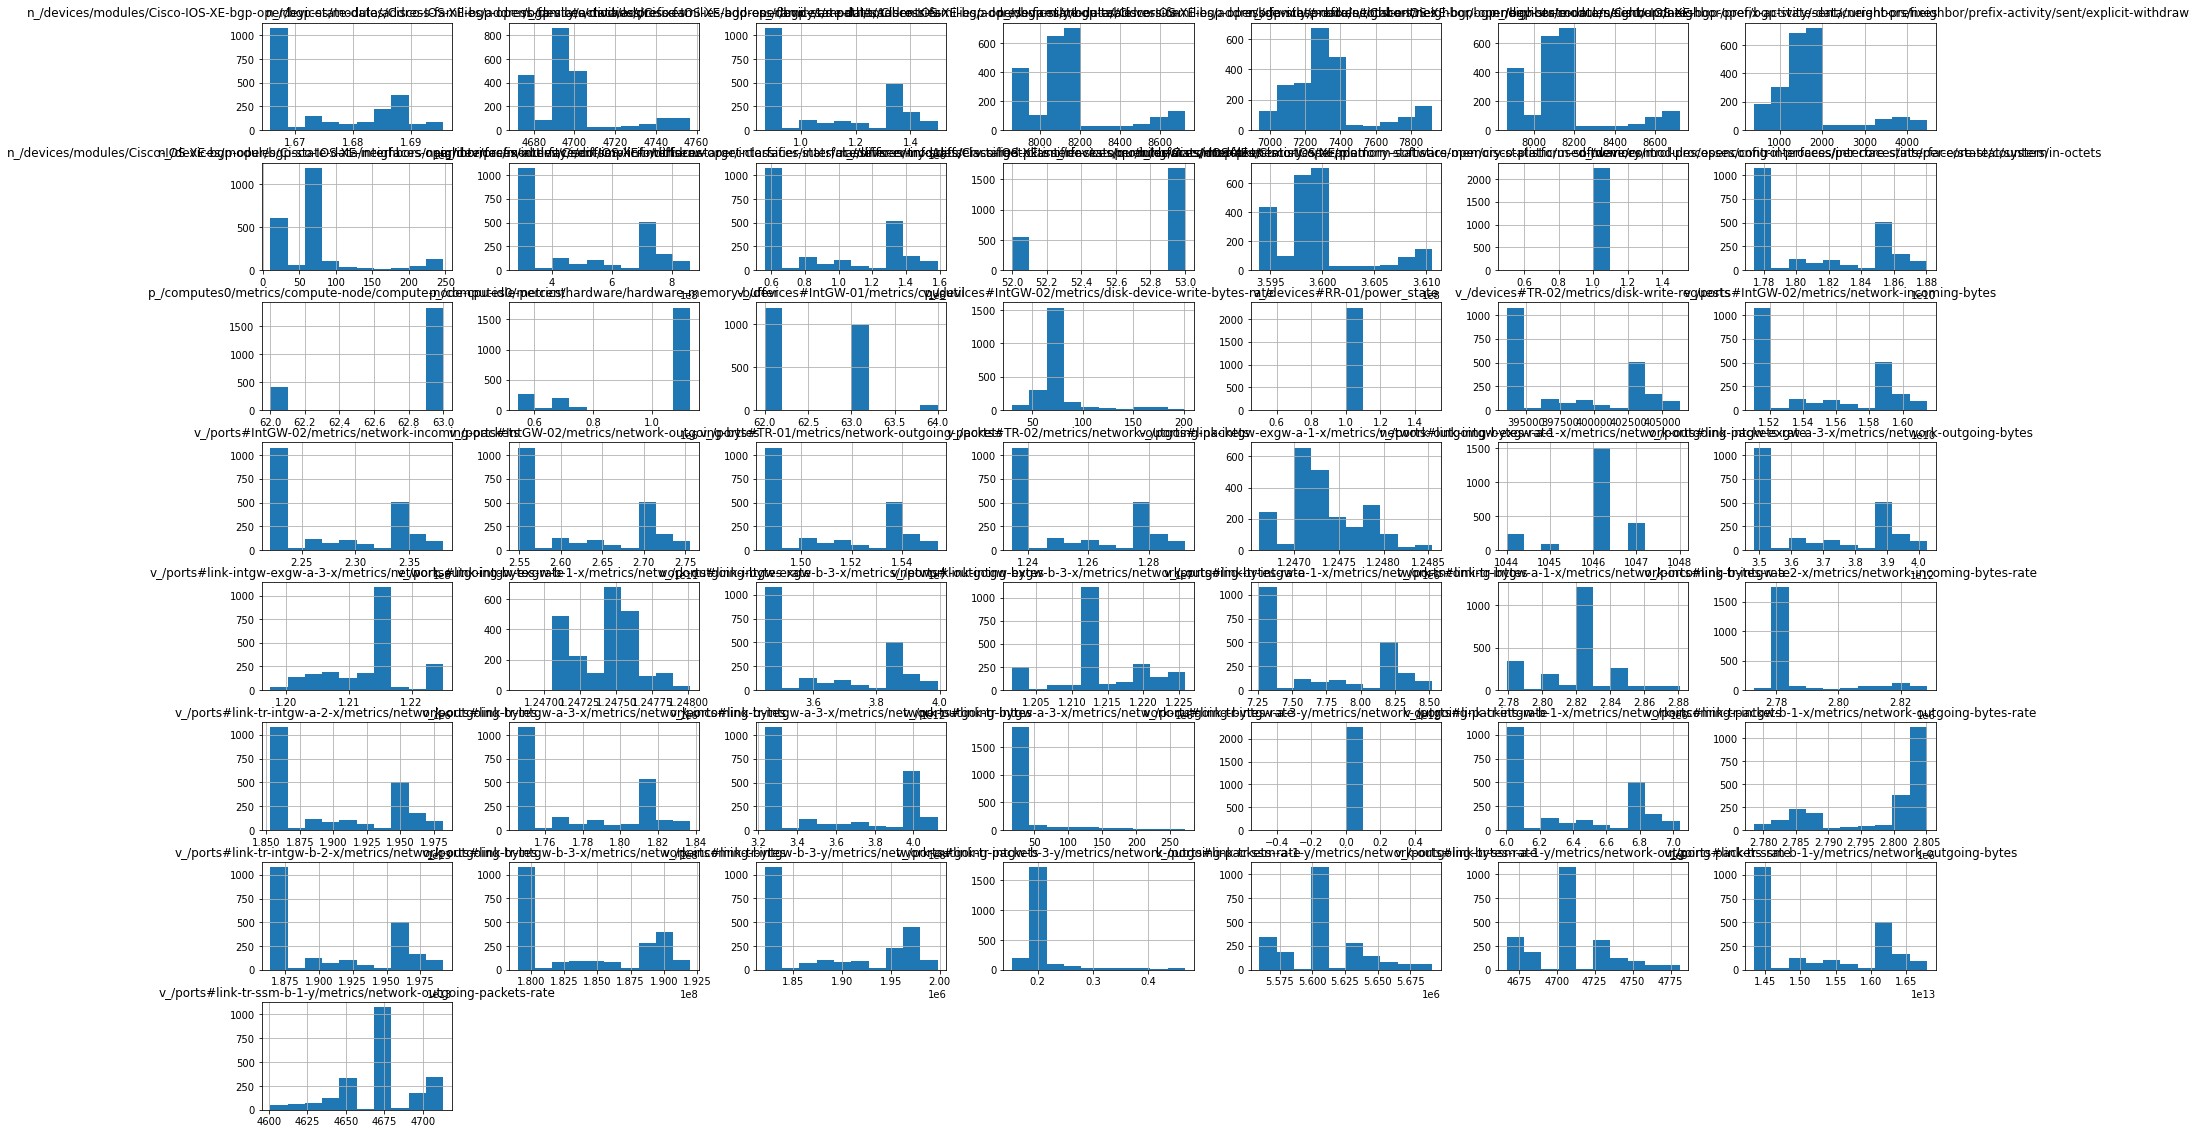

In [180]:
df_final.hist(figsize=(30,20))

array([[<AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-table-version'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/bgp-neighbor-counters/sent/updates'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-d

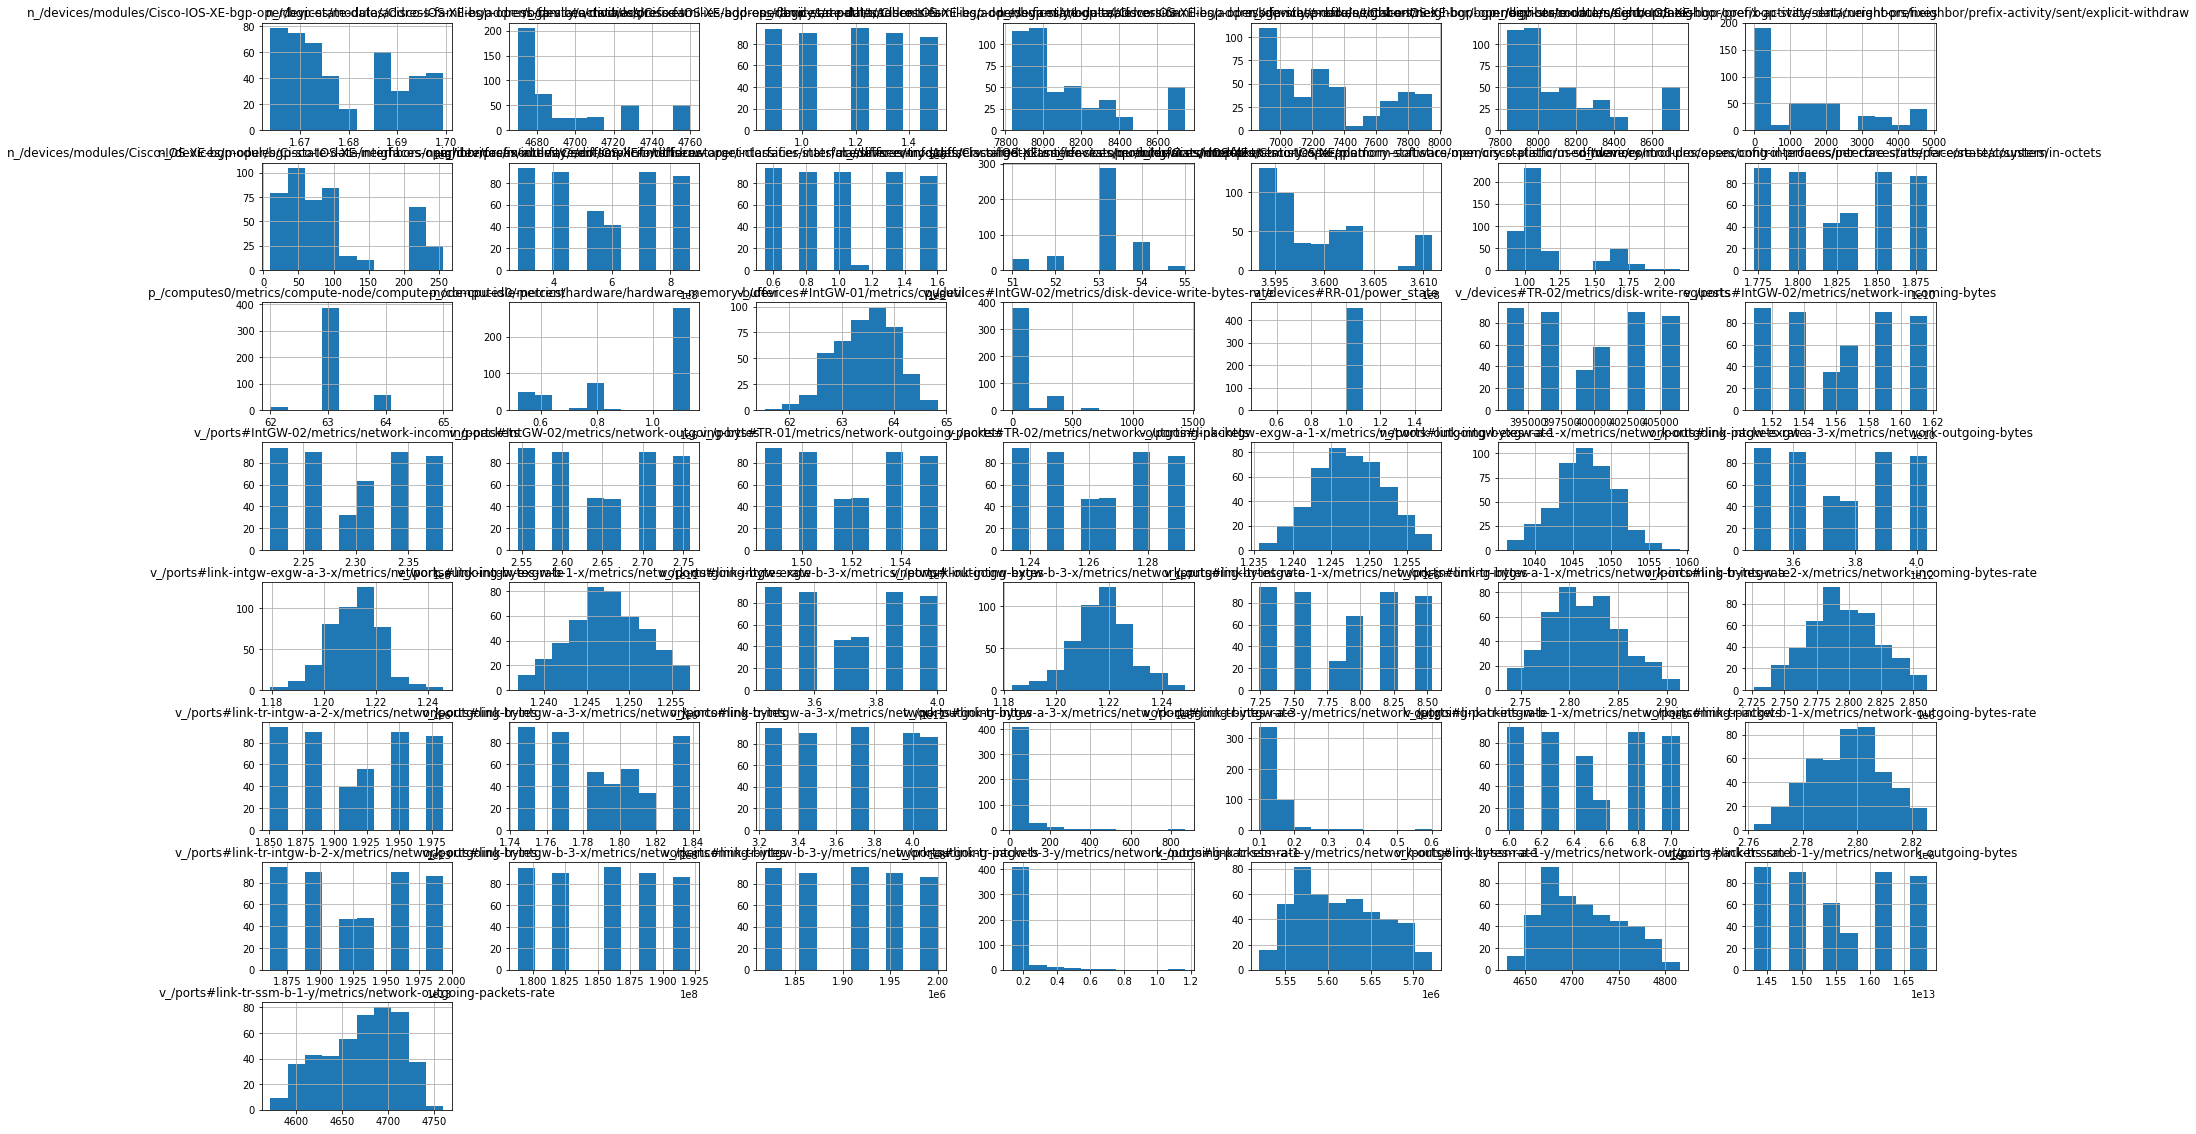

In [181]:
df_ori.hist(figsize=(30,20))

In [182]:
df_final.describe()

,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes,v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries,v_/devices#RR-01/power_state,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts,v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw,...,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/used-memory,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-table-version,v_/devices#IntGW-02/metrics/disk-device-write-bytes-rate,v_/ports#link-tr-intgw-b-3-x/metrics/network-incoming-bytes,v_/devices#IntGW-01/metrics/cpu_util,v_/ports#link-tr-intgw-a-1-x/metrics/network-incoming-bytes-rate,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes,v_/ports#IntGW-02/metrics/network-incoming-packets,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes-rate
count,2.250000e+03,2250.000000,2.250000e+03,2250.000000,2.250000e+03,2250.000000,2250.0,2.250000e+03,2.250000e+03,2250.000000,...,2.250000e+03,2.250000e+03,2250.000000,2.250000e+03,2250.000000,2.250000e+03,2.250000e+03,2.250000e+03,2.250000e+03,2.250000e+03
mean,1.675068e+06,8147.567111,1.519635e+13,4698.396444,1.213563e+06,8148.146667,1.0,9.156090e+07,1.776522e+08,1740.606667,...,3.599559e+08,1.089995e+06,74.781333,1.836297e+08,62.494667,2.819845e+06,3.638933e+12,2.277184e+08,3.672532e+12,1.213806e+06
std,1.017924e+04,206.201491,9.066209e+11,20.153020,6.413770e+03,206.675559,0.0,3.751807e+07,3.316295e+06,881.325788,...,4.027701e+05,2.361691e+05,25.671787,4.881884e+06,0.549237,2.083150e+04,2.023827e+11,5.963781e+06,2.009781e+11,6.007614e+03
min,1.665636e+06,7863.000000,1.434224e+13,4672.000000,1.197540e+06,7863.000000,1.0,5.640312e+07,1.745299e+08,388.000000,...,3.593957e+08,8.669170e+05,30.000000,1.790001e+08,62.000000,2.779310e+06,3.448168e+12,2.220904e+08,3.483148e+12,1.201651e+06
25%,1.665678e+06,8073.500000,1.434446e+13,4690.000000,1.208996e+06,8073.250000,1.0,5.648619e+07,1.745372e+08,1482.000000,...,3.598054e+08,8.673930e+05,69.000000,1.790121e+08,62.000000,2.816634e+06,3.448657e+12,2.221049e+08,3.483635e+12,1.212012e+06
50%,1.671988e+06,8105.000000,1.493713e+13,4694.000000,1.214993e+06,8105.000000,1.0,7.990015e+07,1.767249e+08,1542.000000,...,3.598689e+08,1.022258e+06,69.000000,1.824155e+08,62.000000,2.822451e+06,3.581019e+12,2.260439e+08,3.614840e+12,1.212106e+06
75%,1.683777e+06,8171.000000,1.624909e+13,4700.000000,1.216218e+06,8171.000000,1.0,1.346326e+08,1.813233e+08,1787.000000,...,3.599968e+08,1.364218e+06,73.000000,1.893312e+08,63.000000,2.822792e+06,3.874158e+12,2.346503e+08,3.905891e+12,1.218976e+06
max,1.695660e+06,8724.000000,1.679346e+13,4757.000000,1.225030e+06,8725.000000,1.0,1.587127e+08,1.837240e+08,4476.000000,...,3.610610e+08,1.500013e+06,201.000000,1.919928e+08,64.000000,2.880702e+06,3.993828e+12,2.381414e+08,4.025769e+12,1.225820e+06


In [183]:
df_ori.describe()

,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes,v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries,v_/devices#RR-01/power_state,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts,v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw,...,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/used-memory,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-table-version,v_/devices#IntGW-02/metrics/disk-device-write-bytes-rate,v_/ports#link-tr-intgw-b-3-x/metrics/network-incoming-bytes,v_/devices#IntGW-01/metrics/cpu_util,v_/ports#link-tr-intgw-a-1-x/metrics/network-incoming-bytes-rate,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes,v_/ports#IntGW-02/metrics/network-incoming-packets,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes-rate
count,4.550000e+02,455.000000,4.550000e+02,455.000000,4.550000e+02,455.000000,455.0,4.550000e+02,4.550000e+02,455.000000,...,4.550000e+02,4.550000e+02,455.000000,4.550000e+02,455.000000,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,1.678979e+06,8111.896703,1.554174e+13,4695.268132,1.211906e+06,8112.397802,1.0,1.058250e+08,1.789638e+08,1536.210989,...,3.598782e+08,1.181962e+06,73.045441,1.855112e+08,63.460855,2.816181e+06,3.716056e+12,2.299967e+08,3.749150e+12,1.217050e+06
std,1.144339e+04,258.736638,8.675000e+11,28.482288,1.030285e+04,258.596564,0.0,3.617010e+07,3.214569e+06,1485.577604,...,4.990233e+05,2.252254e+05,171.588550,4.619513e+06,0.563950,3.796772e+04,1.932911e+11,5.685786e+06,1.921124e+11,1.104334e+04
min,1.663801e+06,7836.000000,1.430371e+13,4670.000000,1.179236e+06,7836.000000,1.0,5.499950e+07,1.744120e+08,0.000000,...,3.593430e+08,8.595280e+05,0.000000,1.788003e+08,61.531778,2.735824e+06,3.439740e+12,2.218402e+08,3.474749e+12,1.183249e+06
25%,1.669062e+06,7926.000000,1.493135e+13,4671.000000,1.205265e+06,7926.000000,1.0,7.995033e+07,1.767566e+08,292.000000,...,3.595015e+08,1.024206e+06,0.000000,1.824789e+08,63.045229,2.788677e+06,3.579813e+12,2.260134e+08,3.613675e+12,1.210190e+06
50%,1.674996e+06,8007.000000,1.555573e+13,4686.000000,1.212632e+06,8007.000000,1.0,1.064355e+08,1.791302e+08,1155.000000,...,3.596914e+08,1.196774e+06,0.000000,1.856546e+08,63.496140,2.812835e+06,3.720495e+12,2.301524e+08,3.753355e+12,1.217621e+06
75%,1.688942e+06,8219.000000,1.618954e+13,4714.000000,1.218488e+06,8219.000000,1.0,1.318508e+08,1.810414e+08,2266.000000,...,3.601974e+08,1.349074e+06,0.000000,1.890164e+08,63.878122,2.841639e+06,3.860978e+12,2.342623e+08,3.892605e+12,1.223913e+06
max,1.699461e+06,8745.000000,1.682928e+13,4760.000000,1.245949e+06,8745.000000,1.0,1.602123e+08,1.838709e+08,4802.000000,...,3.610916e+08,1.507911e+06,1433.376537,1.921483e+08,64.838263,2.913256e+06,4.001587e+12,2.383668e+08,4.033583e+12,1.248639e+06
